In [3]:
import json
from langchain_core.documents import Document

output_file = "../../../data/chunked/markdown_header_text_splitter/markdown_header_text_splitter.jsonl"

docs = []
with open(output_file, "r", encoding="utf-8") as f:
    for line in f:
        d = json.loads(line) 
        docs.append(Document(**d))

In [5]:
from transformers import AutoTokenizer

MODEL_ID = "Qwen/Qwen3-Embedding-8B"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, padding_side="left")

texts = [doc.page_content for doc in docs]

# truncation=True로 설정하면 모델 컨텍스트(32k) 초과분은 잘립니다.
enc = tokenizer(
    texts,
    padding=False,        # 배치 토큰 합산이 아니라 각 문장 실제 토큰 수를 보려면 False
    truncation=True,
    return_attention_mask=False,
    add_special_tokens=True,  # [BOS]/[EOS] 등 모델이 기대하는 스페셜 토큰 포함
)

# 각 입력의 실제 토큰 수
token_counts = [len(ids) for ids in enc["input_ids"]]
total_tokens = sum(token_counts)

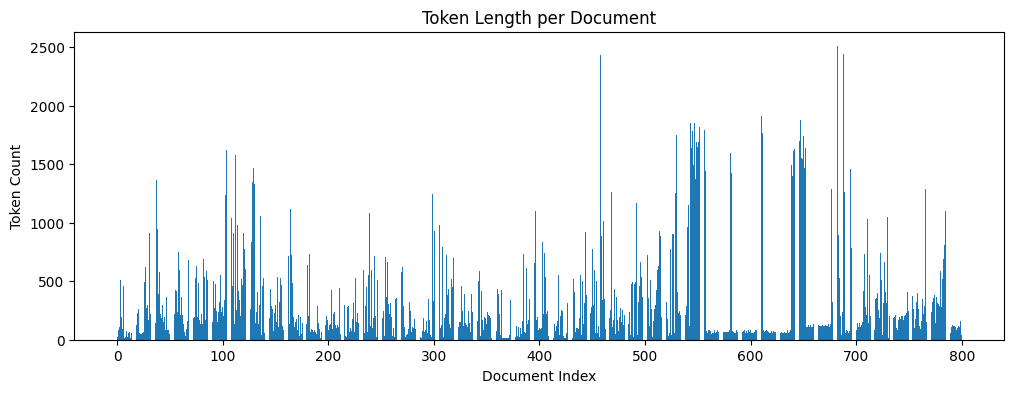

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.bar(range(len(token_counts)), token_counts)
plt.xlabel("Document Index")     # 문서 인덱스
plt.ylabel("Token Count")        # 토큰 수
plt.title("Token Length per Document")  # 문서별 토큰 길이
plt.show()

In [7]:
import heapq

top_k = 5
# 각 doc의 (index, token_count) 준비
indexed_counts = list(enumerate(token_counts))  # [(0, 123), (1, 456), ...]

# 토큰 수 기준 상위 5개 인덱스/카운트
top5 = heapq.nlargest(top_k, indexed_counts, key=lambda x: x[1])

# 보기 좋게 정리
top5_docs = [
    {
        "idx": i,
        "tokens": cnt,
        "metadata": docs[i].metadata,
        "preview": docs[i].page_content[:200].replace("\n", " ")
    }
    for i, cnt in top5
]

for item in top5_docs:
    print(item)

{'idx': 682, 'tokens': 2507, 'metadata': {'Header 1': 'X. 대주주 등과의 거래내용', 'Header 2': '1. 대주주 등에 대한 신용공여 등', 'source': '../../data/raw/[삼성전자]분기보고서(2025.05.15).pdf', 'page': 271, 'total_pages': 302}, 'preview': '# X. 대주주 등과의 거래내용   ## 1. 대주주 등에 대한 신용공여 등   당사는 2025년 1분기말 현재 Samsung Electronics America, Inc. (SEA) 등 해외종속법인의 유연한 자금조달을 위하여 통합채무보증을 제공하고 있습니다   (단위 : 천US$, %)   | 법인명 (채무자) | 관계 | 채권자 | 내용 | 목적 | 보'}
{'idx': 688, 'tokens': 2439, 'metadata': {'Header 1': '4. 채무보증내역', 'source': '../../data/raw/[삼성전자]분기보고서(2025.05.15).pdf', 'page': 275, 'total_pages': 302}, 'preview': '# 4. 채무보증내역   (단위 : 천 US$, %)   | 법인명(채무자) | 관계 | 채권자 | 내용 | 목적 | 보증시작일 | 보증종료일 | 채무보증한도(기초) | 채무보증한도(기말) | 채무금액(기초) | 채무금액(증감) | 채무금액(기말) | 이자율 | |---|---|---|---|---:|---:|---:|---:|---:|---:|---:|-'}
{'idx': 458, 'tokens': 2432, 'metadata': {'Header 1': '(채무보증 내역)', 'Header 2': '2) 해외채무보증', 'source': '../../data/raw/[삼성전자]분기보고서(2025.05.15).pdf', 'page': 180, 'total_pages': 302}, 'preview': '## 2) 해외채무보증   (단위 : 

In [9]:
print(docs[682].page_content)

# X. 대주주 등과의 거래내용  
## 1. 대주주 등에 대한 신용공여 등  
당사는 2025년 1분기말 현재 Samsung Electronics America, Inc. (SEA) 등 해외종속법인의 유연한 자금조달을 위하여 통합채무보증을 제공하고 있습니다  
(단위 : 천US$, %)  
| 법인명 (채무자) | 관계 | 채권자 | 내용 | 목적 | 보증시작일 | 보증종료일 | 채무보증한도(기초) | 채무보증한도(기말) | 채무금액(기초) | 채무금액(증감) | 채무금액(기말) | 이자율 |
|---|---|---|---|---:|---:|---:|---:|---:|---:|---:|---:|---|
| SEA | 계열회사 | BOA 등 | 지급보증 | 운영자금 | 2024.04.20 | 2025.11.08 | 1,278,000 | 1,278,000 | - | - | - | - |
| SEM | 계열회사 | BBVA 등 | 지급보증 | 운영자금 | 2024.03.28 | 2025.12.16 | 715,000 | 715,000 | - | - | - | - |
| SAMCOL | 계열회사 | Citibank 등 | 지급보증 | 운영자금 | 2024.06.14 | 2025.12.16 | 210,000 | 210,000 | - | - | - | - |
| SEDA | 계열회사 | BRADESCO 등 | 지급보증 | 운영자금 | 2024.10.01 | 2025.12.16 | 329,000 | 329,000 | - | - | - | - |
| SECH | 계열회사 | Citibank 등 | 지급보증 | 운영자금 | 2024.06.14 | 2025.12.16 | 62,000 | 64,000 | - | - | - | - |
| SEPR | 계열회사 | BBVA 등 | 지급보증 | 운영자금 | 2024.06.01 | 2025.12.16 | 150,000 | 150,000 | - | - | - | - |
| SSA | 계열회사 | SCB 등 | 지급보증 | 운영자금 | 20

# X. 대주주 등과의 거래내용  
## 1. 대주주 등에 대한 신용공여 등  
당사는 2025년 1분기말 현재 Samsung Electronics America, Inc. (SEA) 등 해외종속법인의 유연한 자금조달을 위하여 통합채무보증을 제공하고 있습니다  
(단위 : 천US$, %)  
| 법인명 (채무자) | 관계 | 채권자 | 내용 | 목적 | 보증시작일 | 보증종료일 | 채무보증한도(기초) | 채무보증한도(기말) | 채무금액(기초) | 채무금액(증감) | 채무금액(기말) | 이자율 |
|---|---|---|---|---:|---:|---:|---:|---:|---:|---:|---:|---|
| SEA | 계열회사 | BOA 등 | 지급보증 | 운영자금 | 2024.04.20 | 2025.11.08 | 1,278,000 | 1,278,000 | - | - | - | - |
| SEM | 계열회사 | BBVA 등 | 지급보증 | 운영자금 | 2024.03.28 | 2025.12.16 | 715,000 | 715,000 | - | - | - | - |
| SAMCOL | 계열회사 | Citibank 등 | 지급보증 | 운영자금 | 2024.06.14 | 2025.12.16 | 210,000 | 210,000 | - | - | - | - |
| SEDA | 계열회사 | BRADESCO 등 | 지급보증 | 운영자금 | 2024.10.01 | 2025.12.16 | 329,000 | 329,000 | - | - | - | - |
| SECH | 계열회사 | Citibank 등 | 지급보증 | 운영자금 | 2024.06.14 | 2025.12.16 | 62,000 | 64,000 | - | - | - | - |
| SEPR | 계열회사 | BBVA 등 | 지급보증 | 운영자금 | 2024.06.01 | 2025.12.16 | 150,000 | 150,000 | - | - | - | - |
| SSA | 계열회사 | SCB 등 | 지급보증 | 운영자금 | 2024.06.14 | 2025.12.16 | 318,000 | 286,000 | - | - | - | - |
| SEMAG | 계열회사 | SocGen 등 | 지급보증 | 운영자금 | 2024.11.09 | 2025.12.16 | 46,000 | 46,000 | - | - | - | - |
| SETK | 계열회사 | BNP 등 | 지급보증 | 운영자금 | 2024.06.14 | 2025.12.16 | 947,000 | 947,000 | 495,321 | △149,623 | 345,699 | 46.9% |
| SETK-P | 계열회사 | BNP 등 | 지급보증 | 운영자금 | 2024.11.09 | 2025.12.16 | 70,000 | 70,000 | - | - | - | - |
| SECE | 계열회사 | Citibank | 지급보증 | 운영자금 | 2024.12.17 | 2025.12.16 | 114,000 | 114,000 | - | - | - | - |
| SEEG | 계열회사 | HSBC | 지급보증 | 운영자금 | 2024.06.14 | 2025.06.13 | 85,000 | 85,000 | - | - | - | - |
| SEIN | 계열회사 | BNP 등 | 지급보증 | 운영자금 | 2024.06.14 | 2025.11.08 | 70,000 | 70,000 | - | - | - | - |
| SJC | 계열회사 | Mizuho Bank 등 | 지급보증 | 운영자금 | 2024.04.28 | 2025.12.16 | 808,270 | 820,741 | - | - | - | - |
| SEUC | 계열회사 | Credit Agricole 등 | 지급보증 | 운영자금 | 2024.06.14 | 2025.12.16 | 125,000 | 115,000 | - | - | - | - |
| SEDAM | 계열회사 | Citibank 등 | 지급보증 | 운영자금 | 2024.06.14 | 2025.12.16 | 537,000 | 537,000 | - | - | - | - |
| SECA | 계열회사 | BOA | 지급보증 | 운영자금 | 2024.11.09 | 2025.11.08 | 70,000 | 70,000 | - | - | - | - |
| SELA | 계열회사 | Citibank | 지급보증 | 운영자금 | 2024.12.17 | 2025.12.16 | 60,000 | 60,000 | - | - | - | - |
| SEEH | 계열회사 | HSBC 등 | 지급보증 | 운영자금 | 2024.06.14 | 2025.12.16 | 906,400 | 938,400 | - | - | - | - |
| SELV | 계열회사 | Citibank | 지급보증 | 운영자금 | 2024.12.17 | 2025.12.16 | 10,000 | 10,000 | - | - | - | - |
| SEIL | 계열회사 | Citibank | 지급보증 | 운영자금 | 2024.12.17 | 2025.12.16 | 15,600 | 15,600 | - | - | - | - |
| SAPL | 계열회사 | BOA 등 | 지급보증 | 운영자금 | 2024.06.14 | 2025.12.16 | 404,000 | 404,000 | - | - | - | - |
| SAVINA | 계열회사 | HSBC | 지급보증 | 운영자금 | 2024.06.14 | 2025.06.13 | 51,000 | 51,000 | - | - | - | - |
| SCIC | 계열회사 | HSBC 등 | 지급보증 | 운영자금 | 2024.06.14 | 2025.12.16 | 270,000 | 270,000 | - | - | - | - |
| SESP | 계열회사 | SCB | 지급보증 | 운영자금 | 2024.11.09 | 2025.11.08 | 30,000 | 30,000 | - | - | - | - |
| SME | 계열회사 | SCB | 지급보증 | 운영자금 | 2024.11.09 | 2025.11.08 | 110,000 | 110,000 | - | - | - | - |
| SAMEX | 계열회사 | Citibank | 지급보증 | 운영자금 | 2024.12.17 | 2025.12.16 | 5,000 | 5,000 | - | - | - | - |
| SEASA | 계열회사 | Citibank | 지급보증 | 운영자금 | 2024.12.17 | 2025.12.16 | 2,000 | 2,000 | - | - | - | - |
| SSAP | 계열회사 | SCB | 지급보증 | 운영자금 | 2024.11.09 | 2025.11.08 | 35,000 | 35,000 | - | - | - | - |
| SEPM | 계열회사 | HSBC | 지급보증 | 운영자금 | 2024.06.14 | 2025.06.13 | 35,000 | 35,000 | - | - | - | - |
| SESAR | 계열회사 | HSBC | 지급보증 | 운영자금 | 2024.06.14 | 2025.06.13 | 20,000 | 20,000 | - | - | - | - |
| SEUZ | 계열회사 | Citibank | 지급보증 | 운영자금 | 2024.12.17 | 2025.12.16 | 10,000 | 20,000 | - | - | - | - |  
전자공시시스템 dart.fss.or.kr  
Page 268